In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import os

from tqdm import tqdm
import numpy as np
import h5py

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [6]:
from aatw.units_constants import *

from config import config_dict, intermediates_dir
config = config_dict['CHIME-nnu30-nra3-ndec3']

## 1. Reach

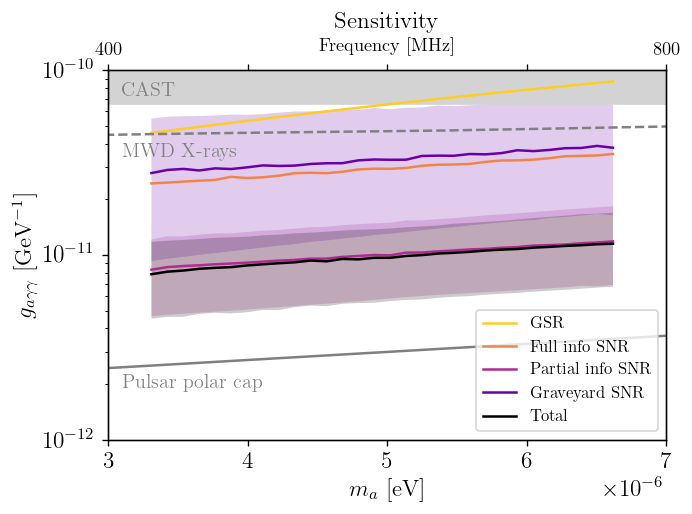

In [35]:
plot_names = ['gsr', 'snrf', 'snrp', 'snrg', 'total']
plot_all_samples = False

label_dict = {
    'gsr' : 'GSR',
    'snrf' : 'Full info SNR',
    'snrp' : 'Partial info SNR',
    'snrg' : 'Graveyard SNR',
    'total' : 'Total',
}
color_dict = {
    'gsr' : cms['plasma'](0.9),
    'snrf' : cms['plasma'](0.7),
    'snrp' : cms['plasma'](0.4),
    'snrg' : cms['plasma'](0.2),
    'total' : 'k',
}
telescope = config['telescope']

fig, ax = plt.subplots()

for pn in plot_names:
    with h5py.File(f"../outputs/plot_data/{pn}.h5", 'r') as hf:
        nu_arr = hf['nu'][:]
        gagg_arr = hf['gagg'][:]
        
        ma_arr = 4*PI*hbar*nu_arr / eV
        
        if gagg_arr.shape[0] == 1:
            ax.plot(ma_arr, gagg_arr[0], color=color_dict[pn], label=label_dict[pn])
        else:
            if plot_all_samples:
                for i, gagg_sample in enumerate(gagg_arr):
                    ax.plot(ma_arr, gagg_sample, color=color_dict[pn], alpha=0.1,
                            label=(label_dict[pn] if i==0 else None), zorder=-1)
            else:
                ax.plot(ma_arr, np.median(gagg_arr, axis=0), color=color_dict[pn], label=label_dict[pn])
                ax.fill_between(ma_arr, np.quantile(gagg_arr, 0.95, axis=0), np.quantile(gagg_arr, 0.05, axis=0),
                                alpha=0.2, facecolor=color_dict[pn], edgecolor='none')

ax.fill_between([1e-6, 1e-5], gagg_CAST/invGeV, 1e-8, color='lightgray')
ax.text(3.1e-6, 7.3e-11, 'CAST', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/PulsarPolarCap.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='-')
ax.text(3.1e-6, 1.9e-12, 'Pulsar polar cap', color='gray')

limit_ma_arr, limit_gagg_arr = np.loadtxt("../data/limits/MWDXrays.txt", unpack=True)
ax.plot(limit_ma_arr, limit_gagg_arr, color='gray', ls='--')
ax.text(3.1e-6, 3.4e-11, 'MWD X-rays', color='gray')

ax.set(xlim=(3e-6, 7e-6), ylim=(1e-12, 1e-10), yscale='log')
ax.set(xlabel='$m_a$ [eV]', ylabel=r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', title='Sensitivity')

ax_top = ax.twiny()
ax_top.set(xlim=(400, 800))
ax_top.set_xlabel('Frequency [MHz]', fontsize=11)
ax_top.set_xticks([400, 500, 600, 700, 800])
ax_top.set_xticklabels(['400', '', '', '', '800'], fontsize=11)
ax_top.xaxis.set_label_coords(0.5, 1.05)

ax.legend(loc='lower right', fontsize=10)
fig.savefig('../outputs/reach.pdf')

## 2. Graveyard samples

In [37]:
zs = np.load(f'{intermediates_dir}/CHIME-nnu30-nra3-ndec3/snr-graveyard-1e-9/snr-inu6-ira1-idec0.npy')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.39it/s]


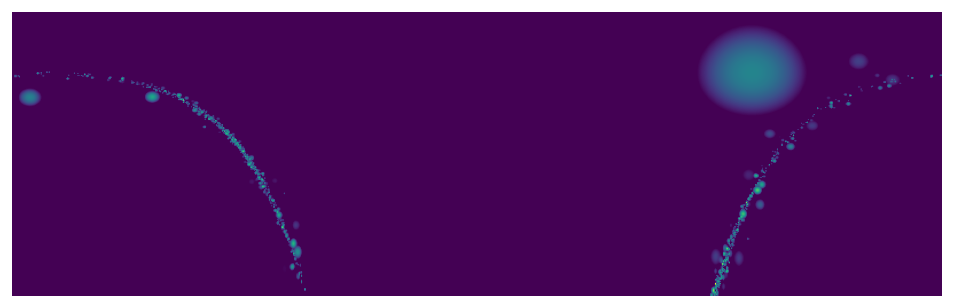

In [48]:
for i in tqdm(range(100)):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.imshow(np.flipud(np.log10(np.clip(zs[i], 1e-9, None))),
              extent=(180, -180, -20, 90), vmin=-9, vmax=-4)
    ax.axis('off')
    fig.savefig(f"../outputs/plot_graveyard_samples/{i}.png", pad_inches=0.)
    if i != 99:
        plt.close()

In [49]:
import glob
from PIL import Image

def create_gif_from_pngs(directory, output_path):
    png_files = glob.glob(directory + '/*.png')
    images = []

    for file in png_files:
        image = Image.open(file)
        images.append(image)

    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

directory_path = '../outputs/plot_graveyard_samples'
output_path = '../outputs/graveyard_samples.gif'

create_gif_from_pngs(directory_path, output_path)